In [1]:
!pip install stim~=1.14
!pip install numpy~=1.0  # 1.0 instead of 2.0 for pymatching compatibility later
!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 2.5 MB/s eta 0:00:00a 0:00:010m


In [1]:
import stim
import numpy as np
import matplotlib.pyplot as plt
import pymatching
print(stim.__version__)

1.14.0


## Trying to create circuit from tableau based on stabilizer generators

In order to encode some codeword in the codespace, I've used this reference:
https://quantumcomputing.stackexchange.com/questions/32437/a-simple-way-of-encoding-qubit-in-stabilizer-codes-with-stim

In [62]:
# circuit helper functions:
def append_stabilizer(circuit, pauli_type, targets):
    """Append a multi-qubit Pauli product measurement to the circuit."""
    pauli_targets = []
    for t in targets:
        if pauli_type == 'X':
            pauli_targets.append(stim.target_x(t))
        elif pauli_type == 'Z':
            pauli_targets.append(stim.target_z(t))
        # Add a combiner for each qubit except the last one
        pauli_targets.append(stim.target_combiner())

    # Remove the last combiner (no combiner after the final target)
    pauli_targets.pop()

    # Append the MPP operation with the constructed targets
    circuit.append("MPP", pauli_targets)

def append_detector(circuit, index1, index2):
    """Append a DETECTOR instruction with two recorded targets."""
    circuit.append("DETECTOR", [
        stim.target_rec(index1),
        stim.target_rec(index2)
    ])

In [63]:
#Code stabilizer definitions:
# X-type stabilizers
x_stabilizers = [
    [0, 1, 2, 3, 4, 5, 6, 7],
    [4, 5, 6, 7, 8, 9, 10, 11],
    [8, 9, 10, 11, 12, 13, 14, 15],
    [0, 1, 4, 5, 8, 9, 12, 13],
    [1, 2, 5, 6, 9, 10, 13, 14],
]

# Z-type stabilizers
z_stabilizers = [
    [0, 1, 2, 3, 4, 5, 6, 7],
    [4, 5, 6, 7, 8, 9, 10, 11],
    [8, 9, 10, 11, 12, 13, 14, 15],
    [0, 1, 4, 5, 8, 9, 12, 13],
    [1, 2, 5, 6, 9, 10, 13, 14],
]

In [65]:
#Circuit created functions:
def init_circuit():
    circuit = stim.Circuit()
    # Adding qubit coordinates metadata
    for qubit in range(16):
        x = qubit % 4
        y = qubit // 4
        circuit.append_operation("QUBIT_COORDS", [qubit], [x, y])
    print("Initialization complete.")
    return circuit

def encode(circuit):
    # Encoding step: Measuring X and Z stabilizers:

    # Append X-type stabilizers
    for targets in x_stabilizers:
        append_stabilizer(circuit, 'X', targets)

    # Append Z-type stabilizers
    for targets in z_stabilizers:
        append_stabilizer(circuit, 'Z', targets)

    print("Encoding complete.")

def channel(circuit, error_rate, noisy_qubits=list(range(16))):
    # Noise channel: Adding X errors with probability 0 (for testing, can be adjusted)
    circuit.append("TICK")
    circuit.append("X_ERROR", noisy_qubits, error_rate)  # 10% error probability for demonstration
    circuit.append("TICK")
    print("Noise channel applied.")

def error_correction(circuit):
    # Error correction: Measuring the stabilizers again

    # Append X-type stabilizers
    for targets in x_stabilizers:
        append_stabilizer(circuit, 'X', targets)

    # Append Z-type stabilizers
    for targets in z_stabilizers:
        append_stabilizer(circuit, 'Z', targets)

    # Adding detectors for error syndrome extraction
    # Append DETECTOR instructions to matching measurements
    for i in range(10):
        append_detector(circuit, index1=-(10 - i), index2=-(20 - i))

    # Logical observables and corresponding observable indices
    logical_observables = [
        (['Z', [0, 4, 8, 12]], 0),
        (['Z', [0, 1, 2, 3]], 1),
        (['Z', [0, 1, 4, 5]], 2),
        (['Z', [5, 6, 9, 10]], 3),
        (['Z', [4, 5, 8, 9]], 4),
        (['Z', [1, 2, 5, 6]], 5),
    ]

    # Append logical observables
    for (pauli_type, targets), observable_index in logical_observables:
        # Append the stabilizer measurement
        append_stabilizer(circuit, pauli_type, targets)

        # Inline the OBSERVABLE_INCLUDE operation
        circuit.append("OBSERVABLE_INCLUDE", [stim.target_rec(-1)], observable_index)

    print("Error correction complete.")

## Creating 1 circuit:

In [66]:

# Initialize the circuit
circuit = init_circuit()

# Encode the logical qubit
encode(circuit)

# Apply noise channel
channel(circuit, 0.5, [0])

# Perform error correction
error_correction(circuit)

# Print the final circuit for verification
print(circuit)

Initialization complete.
Encoding complete.
Noise channel applied.
Error correction complete.
QUBIT_COORDS(0, 0) 0
QUBIT_COORDS(1, 0) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 0) 3
QUBIT_COORDS(0, 1) 4
QUBIT_COORDS(1, 1) 5
QUBIT_COORDS(2, 1) 6
QUBIT_COORDS(3, 1) 7
QUBIT_COORDS(0, 2) 8
QUBIT_COORDS(1, 2) 9
QUBIT_COORDS(2, 2) 10
QUBIT_COORDS(3, 2) 11
QUBIT_COORDS(0, 3) 12
QUBIT_COORDS(1, 3) 13
QUBIT_COORDS(2, 3) 14
QUBIT_COORDS(3, 3) 15
MPP X0*X1*X2*X3*X4*X5*X6*X7 X4*X5*X6*X7*X8*X9*X10*X11 X8*X9*X10*X11*X12*X13*X14*X15 X0*X1*X4*X5*X8*X9*X12*X13 X1*X2*X5*X6*X9*X10*X13*X14 Z0*Z1*Z2*Z3*Z4*Z5*Z6*Z7 Z4*Z5*Z6*Z7*Z8*Z9*Z10*Z11 Z8*Z9*Z10*Z11*Z12*Z13*Z14*Z15 Z0*Z1*Z4*Z5*Z8*Z9*Z12*Z13 Z1*Z2*Z5*Z6*Z9*Z10*Z13*Z14
TICK
X_ERROR(0.5) 0
TICK
MPP X0*X1*X2*X3*X4*X5*X6*X7 X4*X5*X6*X7*X8*X9*X10*X11 X8*X9*X10*X11*X12*X13*X14*X15 X0*X1*X4*X5*X8*X9*X12*X13 X1*X2*X5*X6*X9*X10*X13*X14 Z0*Z1*Z2*Z3*Z4*Z5*Z6*Z7 Z4*Z5*Z6*Z7*Z8*Z9*Z10*Z11 Z8*Z9*Z10*Z11*Z12*Z13*Z14*Z15 Z0*Z1*Z4*Z5*Z8*Z9*Z12*Z13 Z1*Z2*Z5*Z6*Z9*Z10*Z13*Z14

## plot multiple runs with different error rates

Initialization complete.
Encoding complete.
Running simulation for error rate: 0.00
Noise channel applied.
Error correction complete.
Running simulation for error rate: 0.01
Noise channel applied.
Error correction complete.
Running simulation for error rate: 0.03
Noise channel applied.
Error correction complete.
Running simulation for error rate: 0.04
Noise channel applied.
Error correction complete.
Running simulation for error rate: 0.06
Noise channel applied.
Error correction complete.
Running simulation for error rate: 0.07
Noise channel applied.
Error correction complete.
Running simulation for error rate: 0.09
Noise channel applied.
Error correction complete.
Running simulation for error rate: 0.10
Noise channel applied.
Error correction complete.
Running simulation for error rate: 0.12
Noise channel applied.
Error correction complete.
Running simulation for error rate: 0.14
Noise channel applied.
Error correction complete.
Running simulation for error rate: 0.15
Noise channel ap

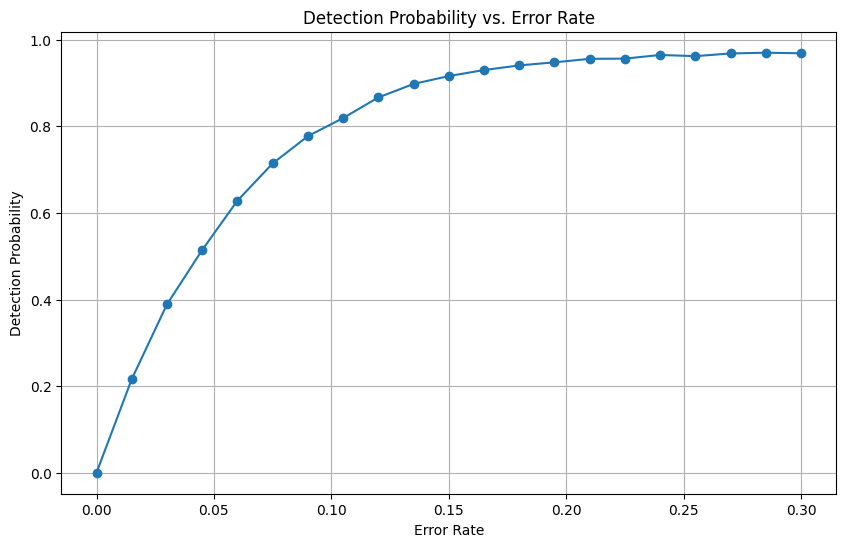

In [58]:
def run_simulation(circuit, error_rate, shots=10000):
    # Apply noise channel with the specified error rate
    channel(circuit, error_rate)

    # Perform error correction
    error_correction(circuit)

    # Compile the circuit and run the simulation
    sampler = circuit.compile_detector_sampler()
    samples = sampler.sample(shots=shots)

    # Calculate the detection probability (fraction of shots with any detection event)
    detection_events = np.any(samples, axis=1)
    detection_probability = np.mean(detection_events)

    return detection_probability

def plot_detection_probability(error_rates, detection_probabilities):
    plt.figure(figsize=(10, 6))
    plt.plot(error_rates, detection_probabilities, marker='o', linestyle='-')
    plt.xlabel("Error Rate")
    plt.ylabel("Detection Probability")
    plt.title("Detection Probability vs. Error Rate")
    plt.grid(True)
    plt.show()

# Initialize the circuit
circuit = init_circuit()

# Encode the logical qubit
encode(circuit)

# Define a range of error rates to test
error_rates = np.linspace(0, 0.3, 21)  # From 0 to 0.2 in steps of 0.01
detection_probabilities = []

# Run the simulation for each error rate
for error_rate in error_rates:
    print(f"Running simulation for error rate: {error_rate:.2f}")
    detection_probability = run_simulation(circuit.copy(), error_rate)
    detection_probabilities.append(detection_probability)

# Plot the results
plot_detection_probability(error_rates, detection_probabilities)

## Plot multiple runs with different error rates - fidelity
(probably not correct, was done with help of GPT)

Initialization complete.
Encoding complete.
Calculating fidelity for error rate: 0.00
Noise channel applied.
Error correction complete.
Calculating fidelity for error rate: 0.01
Noise channel applied.
Error correction complete.
Calculating fidelity for error rate: 0.02
Noise channel applied.
Error correction complete.
Calculating fidelity for error rate: 0.03
Noise channel applied.
Error correction complete.
Calculating fidelity for error rate: 0.04
Noise channel applied.
Error correction complete.
Calculating fidelity for error rate: 0.05
Noise channel applied.
Error correction complete.
Calculating fidelity for error rate: 0.06
Noise channel applied.
Error correction complete.
Calculating fidelity for error rate: 0.07
Noise channel applied.
Error correction complete.
Calculating fidelity for error rate: 0.08
Noise channel applied.
Error correction complete.
Calculating fidelity for error rate: 0.09
Noise channel applied.
Error correction complete.
Calculating fidelity for error rate:

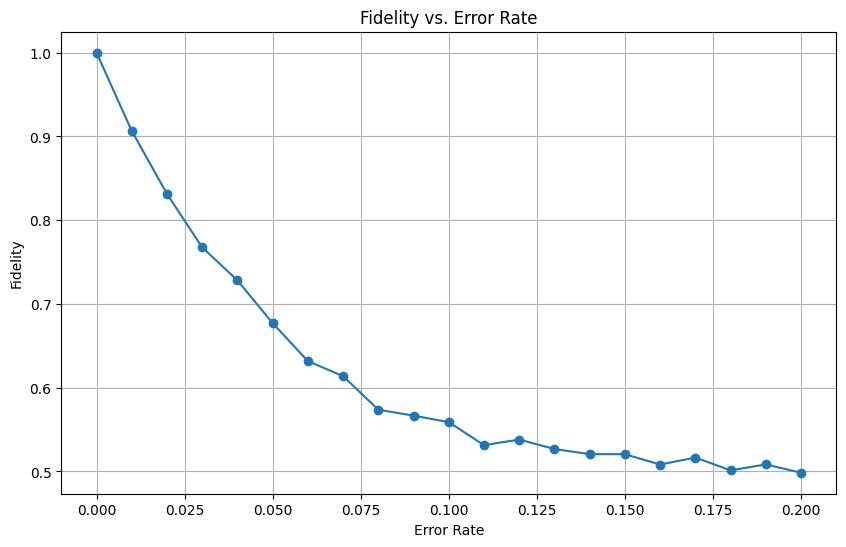

In [44]:
def calculate_fidelity(circuit, error_rate, shots=10000):
    # Apply noise channel and error correction
    channel(circuit, error_rate)
    error_correction(circuit)

    # TODO not sure if this is correct. we don't decode here so how do we know if we have a logical 0? also
    # Logical measurement in the Z basis (ideal state is |0>_L)
    circuit.append("M", list(range(16)))
    sampler = circuit.compile_sampler()
    samples = sampler.sample(shots=shots)

    # Count the fraction of samples where the logical state is measured as |0>_L
    logical_measurements = np.sum(samples, axis=1) % 2  # Parity check
    fidelity = np.mean(logical_measurements == 0)  # Fraction of times we get logical |0>
    return fidelity

def plot_fidelity(error_rates, fidelities):
    plt.figure(figsize=(10, 6))
    plt.plot(error_rates, fidelities, marker='o', linestyle='-')
    plt.xlabel("Error Rate")
    plt.ylabel("Fidelity")
    plt.title("Fidelity vs. Error Rate")
    plt.grid(True)
    plt.show()

# Initialize the circuit
circuit = init_circuit()
encode(circuit)

# Define a range of error rates to test
error_rates = np.linspace(0, 0.2, 21)
fidelities = []

# Run fidelity calculations for each error rate
for error_rate in error_rates:
    print(f"Calculating fidelity for error rate: {error_rate:.2f}")
    fidelity = calculate_fidelity(circuit.copy(), error_rate)
    fidelities.append(fidelity)

# Plot the fidelity results
plot_fidelity(error_rates, fidelities)

In [45]:
circuit.to_crumble_url()

'https://algassert.com/crumble#circuit=Q(0,0)0;Q(1,0)1;Q(2,0)2;Q(3,0)3;Q(0,1)4;Q(1,1)5;Q(2,1)6;Q(3,1)7;Q(0,2)8;Q(1,2)9;Q(2,2)10;Q(3,2)11;Q(0,3)12;Q(1,3)13;Q(2,3)14;Q(3,3)15;MPP_X0*X1*X2*X3*X4*X5*X6*X7_X4*X5*X6*X7*X8*X9*X10*X11_X8*X9*X10*X11*X12*X13*X14*X15_X0*X1*X4*X5*X8*X9*X12*X13_X1*X2*X5*X6*X9*X10*X13*X14_Z0*Z1*Z2*Z3*Z4*Z5*Z6*Z7_Z4*Z5*Z6*Z7*Z8*Z9*Z10*Z11_Z8*Z9*Z10*Z11*Z12*Z13*Z14*Z15_Z0*Z1*Z4*Z5*Z8*Z9*Z12*Z13_Z1*Z2*Z5*Z6*Z9*Z10*Z13*Z14'

In [46]:
sampler = circuit.compile_sampler()
sampler.sample(shots=10)

array([[False, False,  True,  True,  True, False, False, False, False,
        False],
       [ True, False, False,  True, False, False, False, False, False,
        False],
       [ True,  True,  True, False,  True, False, False, False, False,
        False],
       [ True, False,  True, False,  True, False, False, False, False,
        False],
       [ True,  True, False, False, False, False, False, False, False,
        False],
       [False,  True,  True,  True,  True, False, False, False, False,
        False],
       [ True, False, False, False,  True, False, False, False, False,
        False],
       [False, False, False,  True, False, False, False, False, False,
        False],
       [ True, False, False, False,  True, False, False, False, False,
        False],
       [False,  True, False, False,  True, False, False, False, False,
        False]])

In [67]:
sampler = circuit.compile_detector_sampler()
sampler.sample(shots=5)

array([[False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False,  True, False, False,  True,
        False]])

## Error correction with pymatching
Attempt at actually doing the error correction using pymatching
currently not working

In [68]:
# Creating another circuit (Can delete this - duplicate. this is just for easier work)
# Initialize the circuit
circuit = init_circuit()

# Encode the logical qubit
encode(circuit)

# Apply noise channel
# channel(circuit, 0.05)
channel(circuit, 0.05, [0,2,7,12,14])

# Perform error correction
error_correction(circuit)

# Print the final circuit for verification
print(circuit)

Initialization complete.
Encoding complete.
Noise channel applied.
Error correction complete.
QUBIT_COORDS(0, 0) 0
QUBIT_COORDS(1, 0) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 0) 3
QUBIT_COORDS(0, 1) 4
QUBIT_COORDS(1, 1) 5
QUBIT_COORDS(2, 1) 6
QUBIT_COORDS(3, 1) 7
QUBIT_COORDS(0, 2) 8
QUBIT_COORDS(1, 2) 9
QUBIT_COORDS(2, 2) 10
QUBIT_COORDS(3, 2) 11
QUBIT_COORDS(0, 3) 12
QUBIT_COORDS(1, 3) 13
QUBIT_COORDS(2, 3) 14
QUBIT_COORDS(3, 3) 15
MPP X0*X1*X2*X3*X4*X5*X6*X7 X4*X5*X6*X7*X8*X9*X10*X11 X8*X9*X10*X11*X12*X13*X14*X15 X0*X1*X4*X5*X8*X9*X12*X13 X1*X2*X5*X6*X9*X10*X13*X14 Z0*Z1*Z2*Z3*Z4*Z5*Z6*Z7 Z4*Z5*Z6*Z7*Z8*Z9*Z10*Z11 Z8*Z9*Z10*Z11*Z12*Z13*Z14*Z15 Z0*Z1*Z4*Z5*Z8*Z9*Z12*Z13 Z1*Z2*Z5*Z6*Z9*Z10*Z13*Z14
TICK
X_ERROR(0.05) 0 2 7 12 14
TICK
MPP X0*X1*X2*X3*X4*X5*X6*X7 X4*X5*X6*X7*X8*X9*X10*X11 X8*X9*X10*X11*X12*X13*X14*X15 X0*X1*X4*X5*X8*X9*X12*X13 X1*X2*X5*X6*X9*X10*X13*X14 Z0*Z1*Z2*Z3*Z4*Z5*Z6*Z7 Z4*Z5*Z6*Z7*Z8*Z9*Z10*Z11 Z8*Z9*Z10*Z11*Z12*Z13*Z14*Z15 Z0*Z1*Z4*Z5*Z8*Z9*Z12*Z13 Z1*Z2*Z5*Z6*Z9*

In [69]:
# Counting errors using pymatching to create a decoder
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

num_shots = 100_000
num_logical_errors = count_logical_errors(circuit, num_shots)
print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots")

there were 671 wrong predictions (logical errors) out of 100000 shots


In [70]:
# Testing that error model is ok
dem = circuit.detector_error_model(decompose_errors=True)
print(repr(dem))

stim.DetectorErrorModel('''
    error(0.05) D5 D6
    error(0.05) D5 D8 L0 L1 L2
    error(0.05) D5 D9 L1 L5
    error(0.05) D7 D8 L0
    error(0.05) D7 D9
    detector D0
    detector D1
    detector D2
    detector D3
    detector D4
    logical_observable L3
    logical_observable L4
''')
